# Defining new acquisition functions
*Joachim van der Herten*

## Introduction

GPflowOpt implements supports some acquisition functions for common scenarios, such as EI and PoF. However, it is straightforward to implement your own strategy. For most strategies, it is sufficient to implement the `Acquisition` interface. In case a more sophisticated model is needed, this can easily be achieved with GPflow.

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt 
import copy
import gpflow
import gpflowopt
import tensorflow as tf

In [2]:
rng = np.random.RandomState(5)
def camelback(X):
    f = (4. - 2.1*X[:,0]**2 + 0.3* X[:,0]**4) * X[:,0]**2 + np.prod(X,axis=1) + 4 * (X[:,1]**2-1) * X[:,1]**2
    return f[:,None] + rng.rand(X.shape[0], 1) * 0.25

# Setup input domain
domain = gpflowopt.domain.ContinuousParameter('x1', -3, 3) + \
         gpflowopt.domain.ContinuousParameter('x2', -2, 2)

## Augmented expected improvement

As an example on how to implement a custom acquisition function, we illustrate the Augmented EI (Huang et al. 2006), a modification for Expected Improvement for optimization of noisy functions. It is defined as
$$
\alpha_{\text{aEI}}(\mathbf x_{\star}) = \alpha_{\text{EI}}(\mathbf x_{\star}) \left( 1 - \frac{\sigma_n}{\sqrt{\text{Var}\left[ f_{\star}\,|\, \mathbf x, \mathbf y, \mathbf x_{\star} \right] + \sigma_n^2}}\right)
$$

This definition can be interpreted as rescaling of the EI score, with respect to the noise variance. For $\sigma^2_n=0$, the rescale term equals 1 and normal EI is recovered. For $\sigma^2_n > 0$, small prediction variances are punished, which decreases concentration of sampling and enhances exploration.  

To implement this acquisition function, we could override the `build_acquisition` method of `Acquisition`, however in this case its easier to override `ExpectedImprovement` and obtain the EI score through a call to build_acquisition of the parent class. 

In [3]:
class AugmentedEI(gpflowopt.acquisition.ExpectedImprovement):
    def __init__(self, model):
        super(AugmentedEI, self).__init__(model)

    def build_acquisition(self, Xcand):
        ei = super(AugmentedEI, self).build_acquisition(Xcand)
        X = self.models[0].input_transform.build_forward(Xcand)
        _, pvar = self.models[0].wrapped.build_predict(X)
        return tf.multiply(ei, 1 - tf.sqrt(self.models[0].likelihood.variance) 
                           / (tf.sqrt(pvar + self.models[0].likelihood.variance)))

## Results

This small experiment on the six hump camelback illustrates impact of the penalty term.

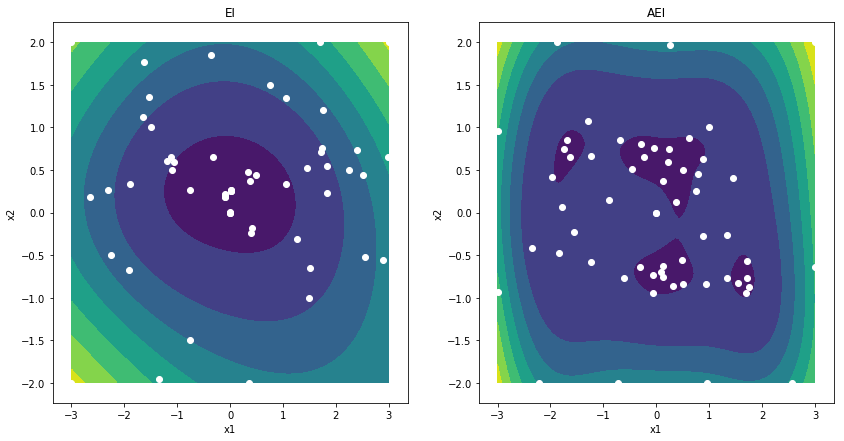

In [4]:
design = gpflowopt.design.LatinHyperCube(9, domain)
X = design.generate()
Y = camelback(X)
m = gpflow.gpr.GPR(X, Y, gpflow.kernels.Matern52(2, ARD=True, lengthscales=[10,10], variance=10000))
m.likelihood.variance = 1
m.likelihood.variance.fixed = True
ei = gpflowopt.acquisition.ExpectedImprovement(m)
m = gpflow.gpr.GPR(X, Y, gpflow.kernels.Matern52(2, ARD=True, lengthscales=[10,10], variance=10000))
m.likelihood.variance = 1
m.likelihood.variance.fixed = False
aei = AugmentedEI(m)

opt = gpflowopt.optim.StagedOptimizer([gpflowopt.optim.MCOptimizer(domain, 200), 
                                       gpflowopt.optim.SciPyOptimizer(domain)])

bopt1 = gpflowopt.BayesianOptimizer(domain, ei, optimizer=opt)
with bopt1.silent():
    bopt1.optimize(camelback, n_iter=50)

bopt2 = gpflowopt.BayesianOptimizer(domain, aei, optimizer=opt)
with bopt2.silent():
    bopt2.optimize(camelback, n_iter=50)

f, axes = plt.subplots(1,2, figsize=(14,7))

Xeval = gpflowopt.design.FactorialDesign(101, domain).generate()
Yeval = camelback(Xeval)
titles = ['EI', 'AEI']
shape = (101, 101)

for ax, t, acq in zip(axes, titles, [ei, aei]):
    pred = acq.models[0].predict_f(Xeval)[0]
    ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), 
                pred.reshape(shape))
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(t)
    ax.scatter(acq.data[0][:,0], acq.data[0][:,1], c='w')